# Calculate cell properties with (optional) classification

This notebook calculates individual cell properties using the outputs of a cellpose segmentation.
Optionally it also uses a cell classifier (trained using the train_cell_classifier.ipynb notebook and the APOC Napari plugin)
Run each block of code in turn by pressing the "run" button.
This first block imports the python packages/functions we need. 
Before running this notebook you will need a python environment with these packages installed, we recommend using annaconda to do this. 
The calc_obj_props function is contained within the utils.py file which should be in the same directory as this notebook.

In [1]:
import glob, os
import numpy as np
import pandas as pd
from skimage.io import imshow, imsave
import apoc
from utils import calc_obj_props
import matplotlib.pyplot as plt
%matplotlib inline  

1. Modify the data_dir variable to the path for your full dataset. This should be a directory containings the cellose .npy outputs (nested directories are ok). Each file should end in _seg.npy as is default for cellpose. 
2. Modify the output_file_path variable to specify where you would like the object properties table to be saved. This should be a full path to a csv file.
3. Modify the output_file_path variable to specify the path to the APOC object classifier you have previously trained. If you dont want to classify cells set this to None (model_path = None).

In [2]:
data_dir = 'Y:/SteveT/jeremy_test/'
output_file_path = 'Y:/SteveT/jeremy_test/obj_properties.csv'
#model_path = None
model_path = 'ObjectClassifier.cl'

This block will load the raw data and masks.

In [3]:
files = glob.glob(data_dir + '/*_seg.npy')
imgs = []
masks = []
for file in files:
    print("loading file: " + file)
    data = np.load(file, allow_pickle=True).item()
    imgs.append(data['img'])
    masks.append(data['masks'])

imgs = np.array(imgs)
masks = np.array(masks)
print("finished loading data")


loading file: Y:/SteveT/jeremy_test\#1_FOV1-05_seg.npy
loading file: Y:/SteveT/jeremy_test\#1_FOV1_seg.npy
loading file: Y:/SteveT/jeremy_test\#2_FOV1-02_seg.npy
loading file: Y:/SteveT/jeremy_test\#2_FOV1-05_seg.npy
loading file: Y:/SteveT/jeremy_test\#3_FOV1-02_seg.npy
loading file: Y:/SteveT/jeremy_test\#3_FOV1-03_seg.npy
loading file: Y:/SteveT/jeremy_test\#3_FOV1-04_seg.npy
finished loading data


If you have specified an object classifer this block will run prediction on the data and save classification masks alongside the traning images.
It will also calulate individual cell measurements which are saved in the file you specifed


running prediction
finished prediction
calculating object properties
finished


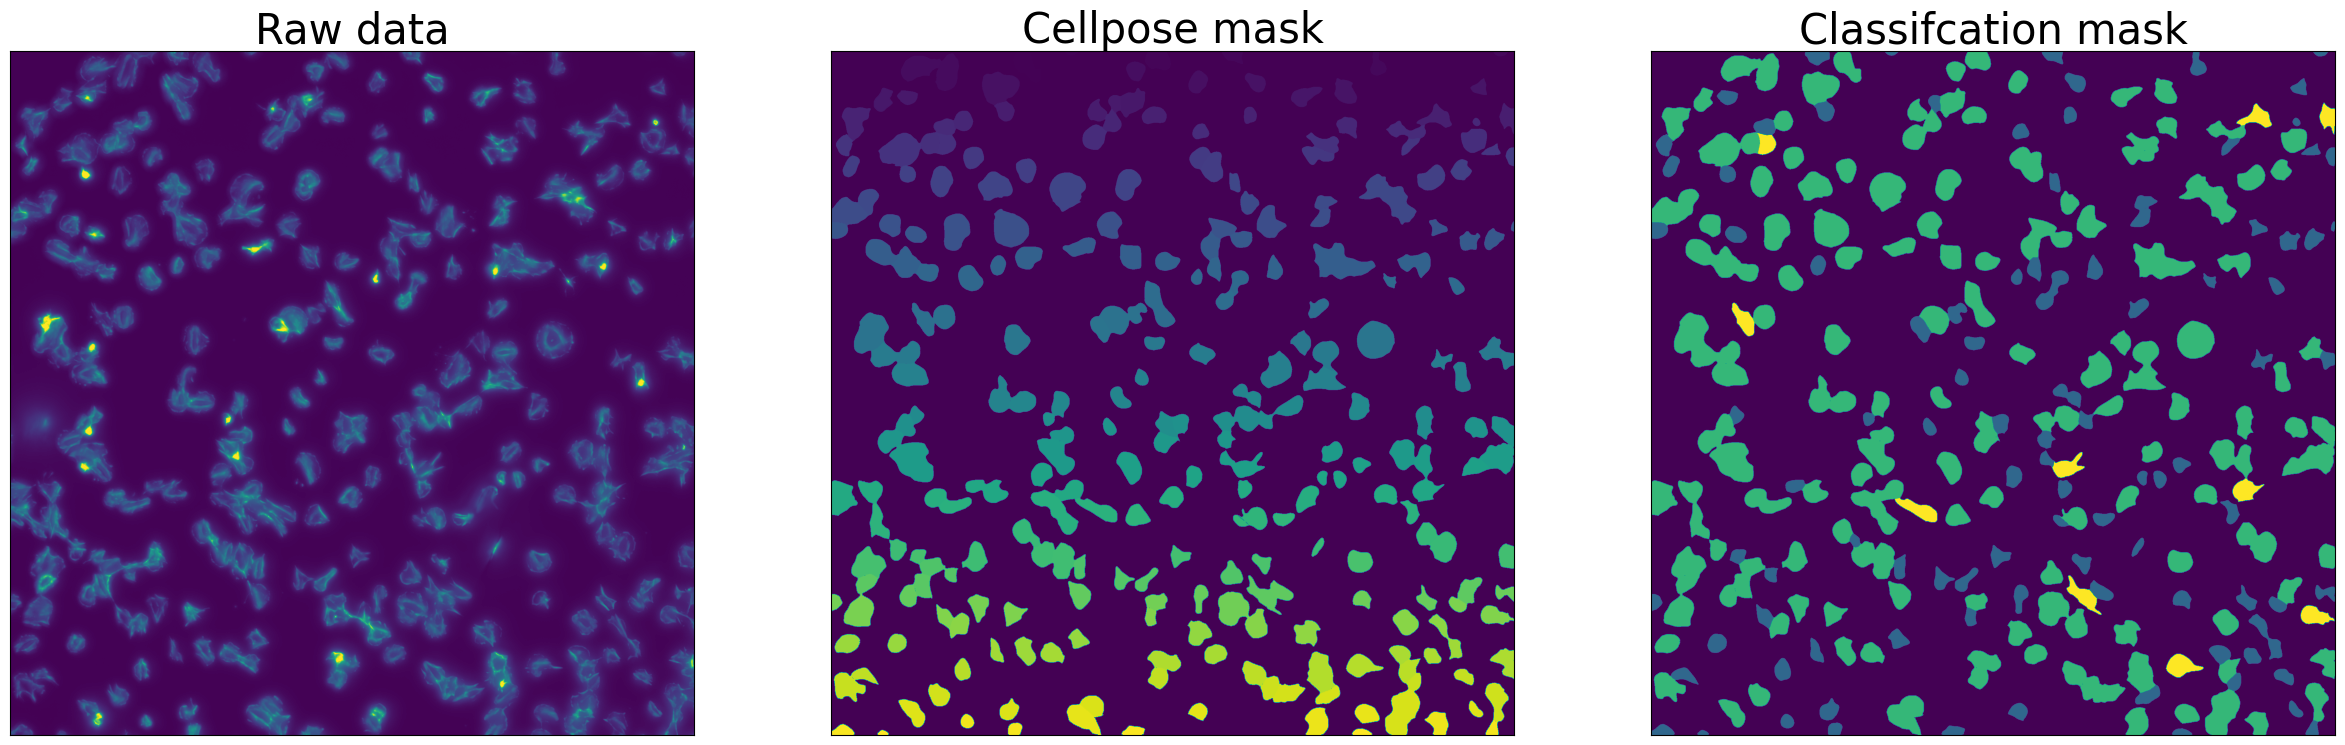

In [4]:
if model_path is not None:
    print("running prediction")
    clf = apoc.ObjectClassifier(opencl_filename=model_path)
    obj_clf_masks = np.array([clf.predict(masks[i], np.squeeze(imgs[i])) for i in range(len(masks))])
    [imsave(files[i].replace('_seg.npy', '_apoc_masks.png'), obj_clf_masks[i], check_contrast=False) for i in range(len(masks))]
    print("finished prediction")
else:
     obj_clf_masks = None   
print("calculating object properties")
obj_df = calc_obj_props(files, masks, imgs, obj_clf_masks=obj_clf_masks)
obj_df.to_csv(output_file_path)
print("finished")

plt.rc('font', size=25)
if model_path is not None:
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
else:
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))   
axs[0].imshow(imgs[0])
axs[0].set_title('Raw data')
axs[1].imshow(masks[0])
axs[1].set_title('Cellpose mask')
if model_path is not None:
    axs[2].imshow(obj_clf_masks[0])
    axs[2].set_title('Classifcation mask')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()